In [1]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large

# Model training
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

2024-03-26 10:12:36.847433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 10:12:36.847530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 10:12:37.015574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Basic Environment Conditions**
* Dataset1: Merged and Augmented UTK Faces and Facial Age 
* Dataset2 : UTK Face new
* Environment: T4 x 2 GPU with Runtime older than Jan 30 From Kaggle ( Due to some Keras issues )

In [2]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

**Provide the Directory of images**

Total number of images  : 234400
Sample Image path       : 90_25_rot_neg40.jpg
Sample Age              : 90


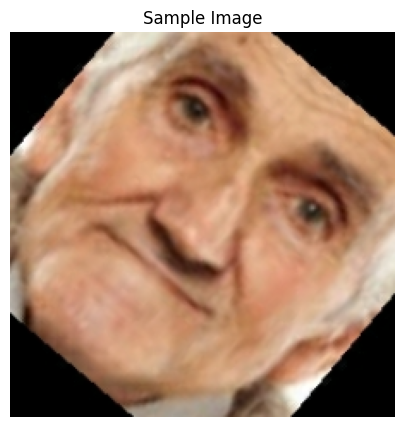

In [3]:
import cv2
#dir_path = "/kaggle/input/utkface-new/UTKFace/"
dir_path = "/kaggle/input/merged-augmented-utk-faces-facial-age-dataset/combined_faces_train_augmented/content/combined_faces_train_augmented/"
image_paths = os.listdir(dir_path)

rand_image_path = np.random.choice(image_paths)
image = tf.io.read_file(dir_path + rand_image_path)
image = tf.io.decode_jpeg(image)
image = tf.cast(image, tf.float32)
image = image/255.
image = tf.image.resize(image, [224,224])
image = tf.reshape(image, [-1,224,224,3])
b,g,r = tf.split(image, num_or_size_splits=3, axis=-1)
image = tf.concat([r,g,b], axis=-1)
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")

plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(image[0])
plt.axis("off")
plt.show()

In [4]:
ages = []
for path in image_paths:
    path_split = path.split("_")
    ages.append(int(path_split[0]))

fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()

In [5]:
# Violin Plot
fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()

In [6]:
np.random.shuffle(image_paths)

v1 = image_paths[:len(image_paths) // 2]
v2 = image_paths[len(image_paths) // 2 : ]
t1, test_images = train_test_split(
    v1,
    train_size = 0.8,
    test_size = 0.2
)

t2, valid_images = train_test_split(
    v2,
    train_size = 0.8,
    test_size = 0.2
)
train_images = t1 +  t2
print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")
print(f"Validating Size  : {len(valid_images)}")

train_ages = [int(path.split("_")[0]) for path in train_images]
valid_ages = [int(path.split("_")[0]) for path in valid_images]
test_ages = [int(path.split("_")[0]) for path in test_images]

Training Size : 187520
Testing Size  : 23440
Validating Size  : 23440


In [7]:
def show_image(image, show=False):
    plt.imshow(image)
    plt.axis("off")

    if show:
        plt.show()


def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)
    b,g,r = tf.split(image, num_or_size_splits=3, axis=-1)
    image = tf.concat([r,g,b], axis=-1)

    return image, age

In [8]:
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_ages)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_ages)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_ages)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

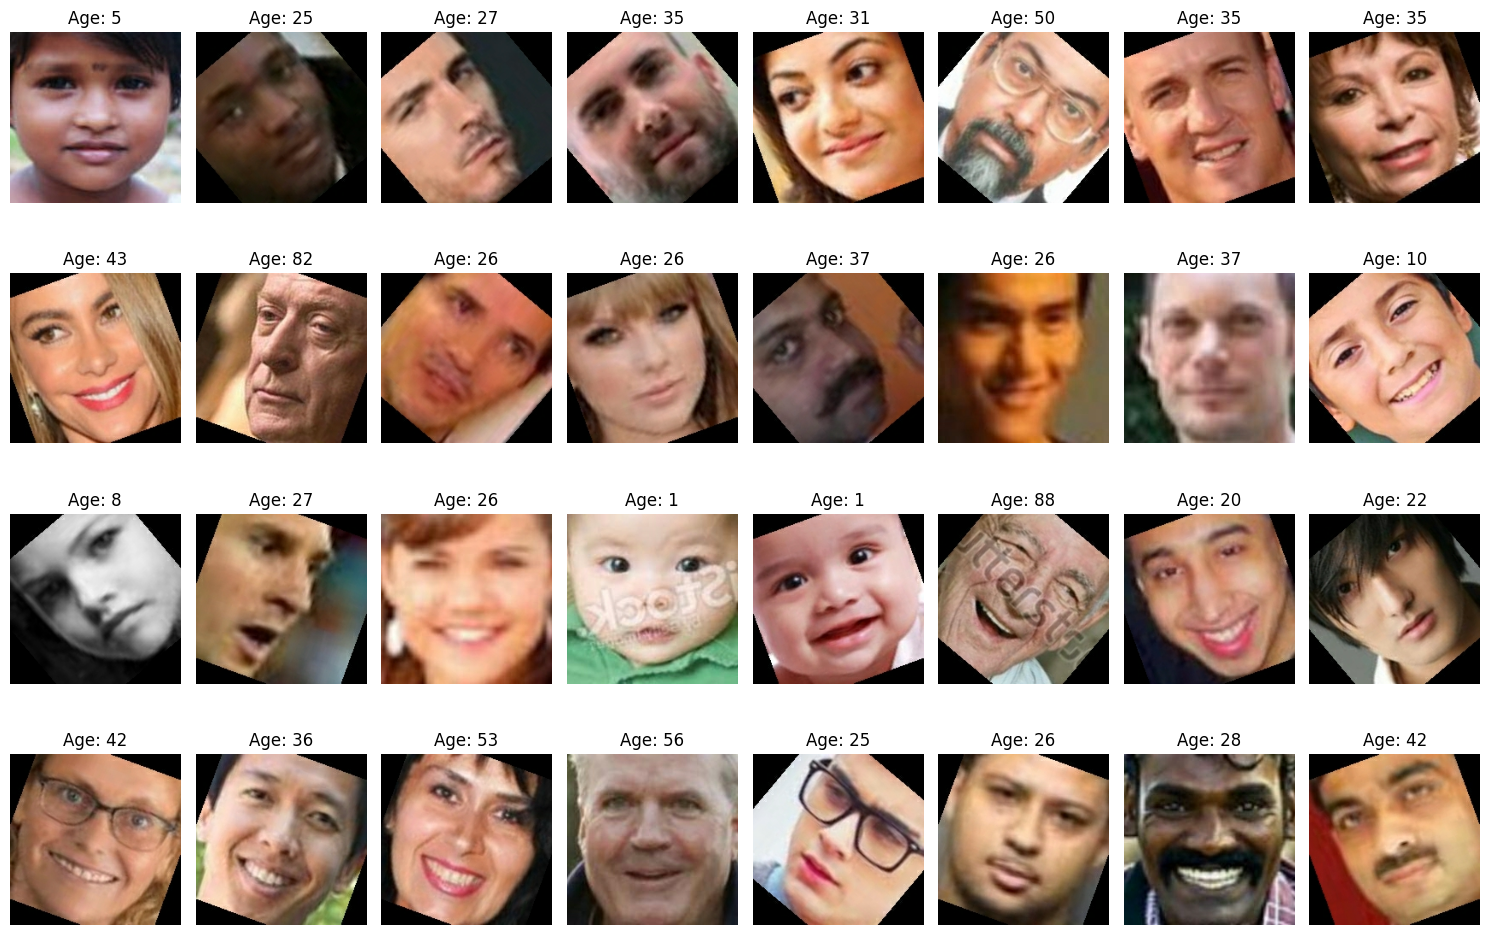

In [9]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        b,g,r = tf.split(image, num_or_size_splits=3, axis=-1)
        image = tf.concat([r,g,b], axis=-1)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

*We tested the models like Mobilenet small, Mobilenet large, Xception, Vgg16, Resnet 150 and Resnet 50 , we found for age prediction the Vgg16 performed far better in our controlled testing.*

In [10]:
vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")

vgg_16.trainable = False
age_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    vgg_16,
    Dropout(0.4, name = "SlightDroput"),
    Flatten(name="FlattenEmbeddings"),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dense(1, name="AgeOutput")
], name="AgeNet")

age_net.compile(
    loss = "mae",
    optimizer = 'adam',
    weighted_metrics=[]
)

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
age_history = age_net.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_loss",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Age-VGG16.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20


2024-03-26 10:13:09.315808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inAgeNet/SlightDroput/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711448000.328965      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5860/5860 [==============================] - 1066s 180ms/step - loss: 8.6179 - val_loss: 7.3139
Epoch 2/20
5860/5860 [==============================] - 1056s 180ms/step - loss: 7.7344 - val_loss: 7.0070
Epoch 3/20
5860/5860 [==============================] - 1057s 180ms/step - loss: 7.4020 - val_loss: 6.8280
Epoch 4/20
5860/5860 [==============================] - 1056s 180ms/step - loss: 7.1449 - val_loss: 6.6803
Epoch 5/20
5860/5860 [==============================] - 1059s 181ms/step - loss: 6.9913 - val_loss: 6.6086
Epoch 6/20
5860/5860 [==============================] - 1057s 180ms/step - loss: 6.8502 - val_loss: 6.4418
Epoch 7/20
5860/5860 [==============================] - 1056s 180ms/step - loss: 6.7287 - val_loss: 6.8740
Epoch 8/20
5860/5860 [==============================] - 1056s 180ms/step - loss: 6.6520 - val_loss: 6.4484
Epoch 9/20
5860/5860 [==============================] - 1057s 180ms/step - loss: 6.5618 - val_loss: 6.3764
Epoch 10/20
5860/5860 [=========================

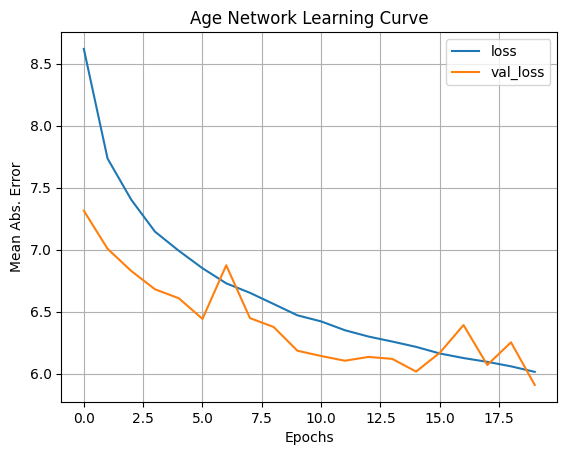

In [12]:
age_his_df = pd.DataFrame(age_history.history)
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

*Results are promising and the model also does'nt look like it has over learned*

In [13]:
from tensorflow.keras.models import load_model
age_net.save('test.keras')

In [14]:
agenet = load_model('/kaggle/working/Age-VGG16.keras')

In [15]:
agenet.evaluate(test_age_ds)

733/733 [==============================] - 103s 140ms/step - loss: 5.9001


5.900092601776123

*We created two models this way for the two datasets mentioned based on distribution of photos age wise
the Model trained on dataset1 ( UTK original ) did not perform well for babies. The Model trained on dataset2 ( Augmented UTK + Facial age ) performed well for middle age and for babies, children.
So after thorough testing here and in inference on 25% of UTK*
* Mae on Dataset1 model was 5.88922 ( in inference )
* Mae on Dataset2 model was 5.61438 ( in inference)
* Hence in our pipeline we will be using VGG 16 trained on Augmented Dataset of Facial Age and UTK face.

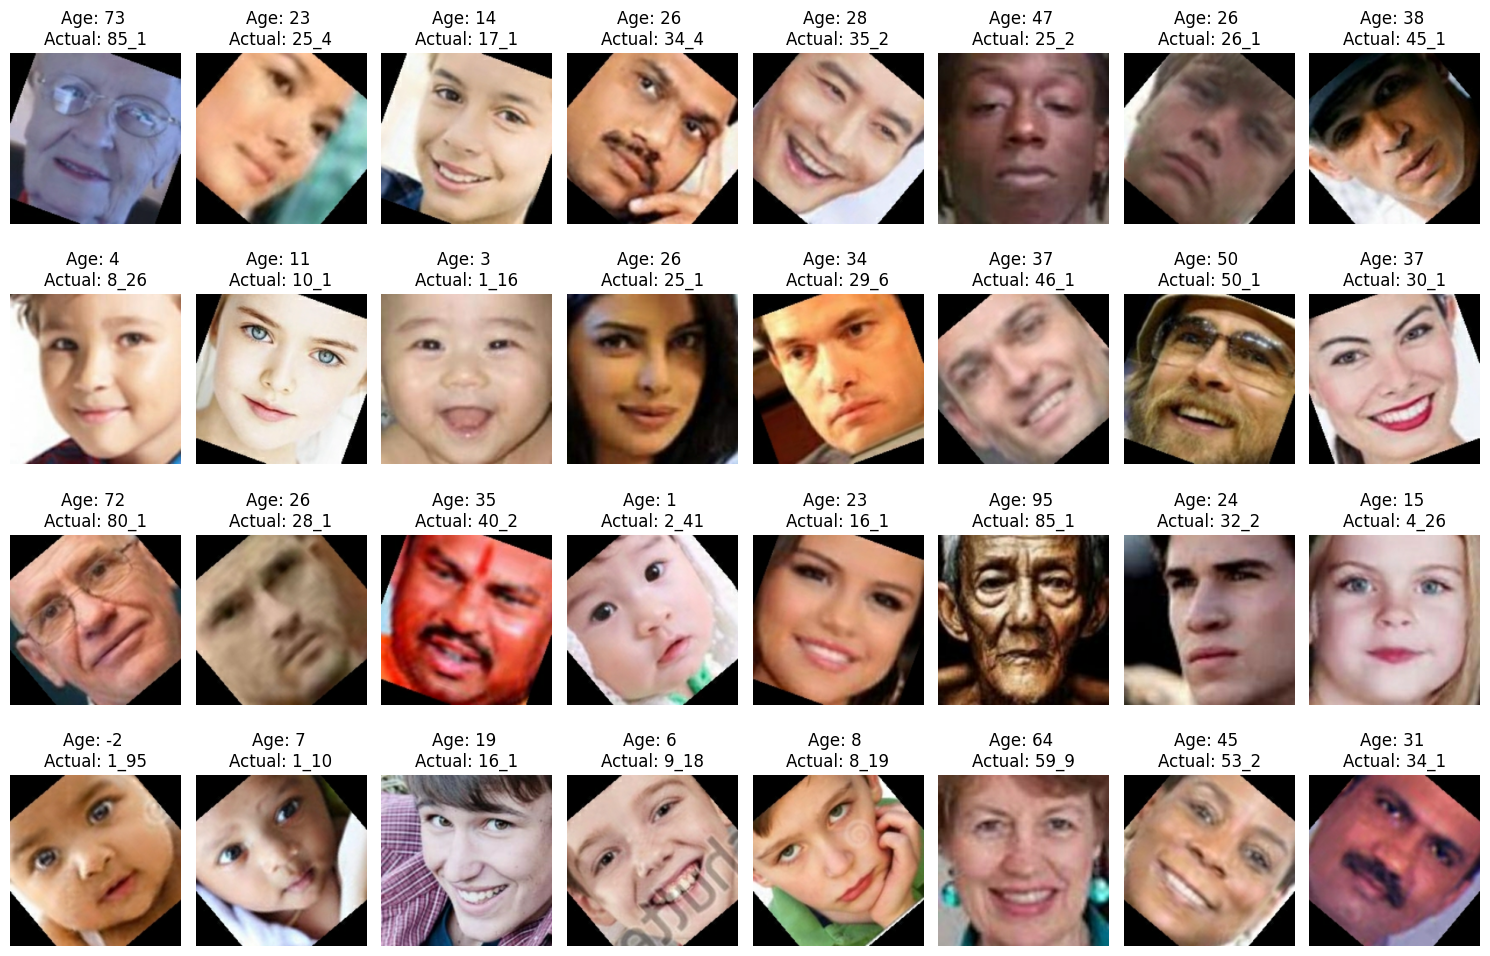

In [16]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        b,g,r = tf.split(image, num_or_size_splits=3, axis=-1)
        image = tf.concat([r,g,b], axis=-1)
        # Predictions
        pred_age = tf.round(tf.squeeze(age_net.predict(image, verbose=0)), 2)
        string_value = images[index].numpy().decode('utf-8')
        ftc = string_value[:4]
        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_age)} \nActual: {ftc}")
        plt.axis("off")

plt.tight_layout()
plt.show()